## chartbusters-prediction-foretell-the-popularity-of-songs

In this hackathon Project done by https://www.machinehack.com/course/chartbusters-prediction-foretell-the-popularity-of-songs/. we have to create prediction algorithm that can predict the views for a given song.

### Getting Started

In this project, we will analyze a dataset that describes popularity of songs. One of the objectives of this project is to help our customer understand user behaviour and personalize the user experience. 

The dataset can be found in the same directory. The dataset includes features such as

- **Unique_ID** : Unique Identifier.
- **Name** : Name of the Artist.
- **Genre** : Genre of the Song.
- **Country** : Origin Country of Artist.
- **Song_Name** : Name of the Song.
- **Timestamp** : Release Date and Time.
- **Views** : Number of times the song was played/viewed (*Target/Dependent Variable*).
- **Comments** : Count of comments for the song.
- **Likes** : Count of Likes.
- **Popularity** : Popularity score for the artist.
- **Followers** : Number of Followers.

#### This notebook predict the Views of songs

### Installing Dependicies

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor,LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.decomposition import PCA
import datetime as dt
from datetime import timedelta
import pickle

### Preprocessing and Exploring the Dataset

**Importing the Dataset spam.csv**

In [84]:
data = pd.read_csv('./data/Data_Train.csv')

In [85]:
data.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


Here we will drop row which containing null song name

In [87]:
null_columns = data.columns[data.isnull().any()]
null_colmn_value_sum=data[null_columns].isnull().sum()
null_colmn_value_sum

Song_Name    1
dtype: int64

In [88]:
data.dropna(axis=0,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78457 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78457 non-null int64
Name          78457 non-null object
Genre         78457 non-null object
Country       78457 non-null object
Song_Name     78457 non-null object
Timestamp     78457 non-null object
Views         78457 non-null int64
Comments      78457 non-null int64
Likes         78457 non-null object
Popularity    78457 non-null object
Followers     78457 non-null int64
dtypes: int64(4), object(7)
memory usage: 7.2+ MB


Dropping Unnecesary columns from DataFrame

In [89]:
data.drop(columns=['Unique_ID','Country','Name'],axis=1,inplace=True)

In [90]:
#Checking for duplicate songs
data[data['Song_Name'].duplicated()]

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers


#### Converted likes and popularity to respective integer counts as 1K to 1000 , 1M to 1000000

In [91]:
#function to convert data value containing 1K to 1000 or 1M to 1000000 respectively
def popularityConverting(x):
    if x[-1]=='K':
        x= ''.join(x[:-1].split(','))
        x=float(x)*1000
    elif x[-1]=='M':
        x= ''.join(x[:-1].split(','))
        x=float(x)*1000000
    else:
        x= ''.join(x.split(','))
    return x

In [92]:
data['Popularity'] = data.Popularity.apply(popularityConverting)
data['Popularity'] = data.Popularity.astype('float')
data['Likes'] = data.Likes.apply(popularityConverting)
data['Likes'] = data.Likes.astype('float')

In [93]:
#pd.plotting.scatter_matrix(data, alpha=0.3, figsize=(14,8), diagonal='kde');

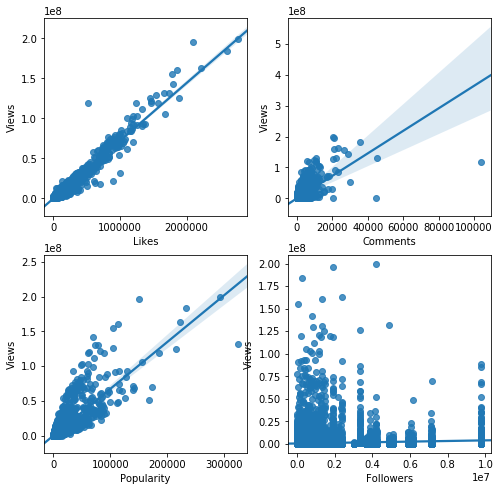

In [94]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.regplot(x="Likes", y="Views", data=data)
plt.subplot(2,2,2)
sns.regplot(x="Comments", y="Views", data=data)
plt.subplot(2,2,3)
sns.regplot(x="Popularity", y="Views", data=data)
plt.subplot(2,2,4)
sns.regplot(x="Followers", y="Views", data=data)

In [95]:
data.groupby(['Genre'])['Views'].mean()

Genre
all-music               2.451156e+06
alternativerock         8.545917e+05
ambient                 3.985286e+05
classical               3.931904e+05
country                 2.945058e+05
danceedm                2.667007e+05
deephouse               6.264949e+04
disco                   3.681520e+05
drumbass                3.712738e+04
dubstep                 2.407431e+05
electronic              1.736528e+05
folksingersongwriter    4.753422e+05
hiphoprap               2.145161e+06
indie                   1.657772e+06
latin                   2.364045e+05
metal                   1.288263e+05
pop                     3.608129e+05
rbsoul                  6.094165e+05
reggaeton               1.149190e+06
rock                    1.325153e+05
trap                    2.763905e+05
Name: Views, dtype: float64

### Feature Engineering

Here we have taken Now as a Date 2019/ 2/ 27 , From this date we have calculated date difference (oldness) of song 
So that we can calculate date Like Per Date which give **Likes given per day average** 
Same we have done for followers_per_date , Popularity_per_date which we have used for predicting Views

In [96]:
NOW = dt.datetime(2019, 2, 27)
data['Timestamp'] =pd.to_datetime(data['Timestamp'])
data['date_old']=(NOW-data['Timestamp']).dt.days
data['like_per_date']=data['Likes']/data['date_old']
data['followers_per_date']=data['Followers']/data['date_old']
data['Popularity_per_date']=data['Popularity']/data['date_old']
data.head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,date_old,like_per_date,followers_per_date,Popularity_per_date
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45,14017,4,499.0,97.0,119563,333,1.498498,359.048048,0.291291
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52,1918,17,49.0,17.0,2141,981,0.049949,2.182467,0.017329
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59,9668,11,312.0,91.0,22248,1390,0.224460,16.005755,0.065468
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03,113036,2,2400.0,76.0,393655,628,3.821656,626.839172,0.121019
4,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19,110024,81,3031.0,699.0,201030,892,3.397982,225.369955,0.783632


#### One Hot Encoding : Genre Column

In [97]:
data_new= pd.get_dummies(data.loc[:,['Comments', 'Likes', 'Popularity','like_per_date','Popularity_per_date',\
                                     'Followers','Genre']],columns=['Genre'],drop_first=True)

In [98]:
data.corr()

,Views,Comments,Likes,Popularity,Followers,date_old,like_per_date,followers_per_date,Popularity_per_date
Views,1.000000,0.679107,0.980132,0.834635,0.103603,0.008631,0.459671,0.004738,0.437701
Comments,0.679107,1.000000,0.656648,0.641818,0.085034,0.006908,0.540796,0.012755,0.674046
Likes,0.980132,0.656648,1.000000,0.869048,0.110321,0.003698,0.478396,0.005664,0.418447
Popularity,0.834635,0.641818,0.869048,1.000000,0.138454,0.041308,0.293431,0.000447,0.374552
Followers,0.103603,0.085034,0.110321,0.138454,1.000000,0.179522,0.039548,0.177716,0.047431
date_old,0.008631,0.006908,0.003698,0.041308,0.179522,1.000000,-0.068360,-0.061376,-0.062460
like_per_date,0.459671,0.540796,0.478396,0.293431,0.039548,-0.068360,1.000000,0.090036,0.807086
followers_per_date,0.004738,0.012755,0.005664,0.000447,0.177716,-0.061376,0.090036,1.000000,0.095805
Popularity_per_date,0.437701,0.674046,0.418447,0.374552,0.047431,-0.062460,0.807086,0.095805,1.000000


In [99]:
data.describe()
#if mean and median not equal outliers ??

,Views,Comments,Likes,Popularity,Followers,date_old,like_per_date,followers_per_date,Popularity_per_date
count,7.845700e+04,78457.000000,7.845700e+04,78457.000000,7.845700e+04,78457.000000,78457.000000,7.845700e+04,78457.000000
mean,5.469740e+05,115.265559,8.821561e+03,920.834992,4.787668e+05,994.554941,22.304639,1.608082e+03,1.725872
std,3.883110e+06,724.617900,5.277471e+04,4810.404229,1.168127e+06,1018.430752,191.924312,1.792715e+04,12.508010
min,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00,1.000000,0.000000,9.269988e-03,0.000000
25%,6.216000e+03,1.000000,1.290000e+02,13.000000,1.770000e+04,298.000000,0.200441,2.933043e+01,0.021019
50%,2.538600e+04,12.000000,6.660000e+02,87.000000,8.768200e+04,767.000000,1.297659,1.255202e+02,0.168457
75%,1.201200e+05,61.000000,2.857000e+03,405.000000,3.936550e+05,1403.000000,6.183333,5.513894e+02,0.845787
max,1.994050e+08,104082.000000,2.770000e+06,324000.000000,9.789123e+06,16858.000000,19222.222222,1.780013e+06,2262.962963


In [100]:
features_data=['Comments', 'Likes', 'Popularity', 'like_per_date',
       'Popularity_per_date', 'Followers', 'Genre_alternativerock',
       'Genre_ambient', 'Genre_classical', 'Genre_country', 'Genre_danceedm',
       'Genre_deephouse', 'Genre_disco', 'Genre_drumbass', 'Genre_dubstep',
       'Genre_electronic', 'Genre_folksingersongwriter', 'Genre_hiphoprap',
       'Genre_indie', 'Genre_latin', 'Genre_metal', 'Genre_pop',
       'Genre_rbsoul', 'Genre_reggaeton', 'Genre_rock', 'Genre_trap']
#features_data

In [101]:
X = data_new[features_data]
y = data['Views']
X.head()

,Comments,Likes,Popularity,like_per_date,Popularity_per_date,Followers,Genre_alternativerock,Genre_ambient,Genre_classical,Genre_country,...,Genre_folksingersongwriter,Genre_hiphoprap,Genre_indie,Genre_latin,Genre_metal,Genre_pop,Genre_rbsoul,Genre_reggaeton,Genre_rock,Genre_trap
0,4,499.0,97.0,1.498498,0.291291,119563,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,49.0,17.0,0.049949,0.017329,2141,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,312.0,91.0,0.224460,0.065468,22248,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,2400.0,76.0,3.821656,0.121019,393655,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,81,3031.0,699.0,3.397982,0.783632,201030,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape

(54919, 26)

#### Dimenshion Reduction : PCA 

[0.12912044 0.05419281 0.04652355 0.04310385 0.04124074 0.04096238
 0.04052563 0.03977466 0.03967267 0.03912047 0.03897657 0.03885792
 0.03880988 0.0387497  0.03870004 0.03860346 0.03851838 0.03850384
 0.0384905  0.03847823 0.03839604 0.03269133 0.01317417 0.00672252
 0.00548207 0.00260815]
[0.12912044 0.18331325 0.2298368  0.27294065 0.31418138 0.35514377
 0.3956694  0.43544406 0.47511672 0.5142372  0.55321377 0.59207169
 0.63088157 0.66963127 0.70833131 0.74693476 0.78545314 0.82395699
 0.86244748 0.90092571 0.93932176 0.97201309 0.98518726 0.99190978
 0.99739185 1.        ]


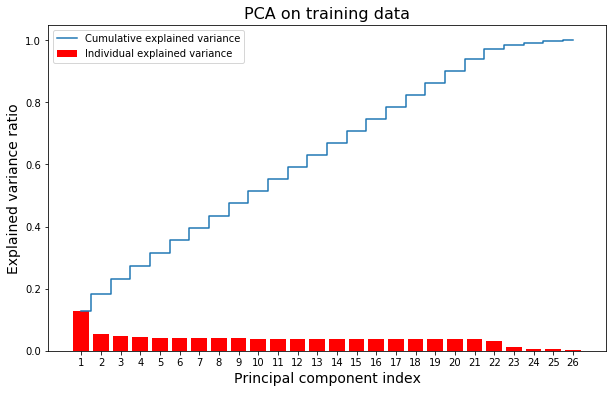

In [103]:
# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
print(pca.explained_variance_ratio_)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(range(1, 27), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 27), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 27))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});
print(cum_var_exp)

We can see that almost 20 features are contributing for 90 % of variation So we will **not do dimenshion reduction** else it will loss data information

### Model Training

### Linear Regression

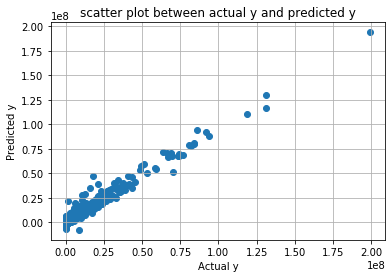

RMSE: 632023.223058


In [104]:
lr_regressor =LinearRegression()
lr_regressor.fit(X_train, y_train)
preds = lr_regressor.predict(X_test)
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


### Lasso Regression

In [105]:
lasso_params = {'alpha':[0.005,0.001, 0.02, 0.03, 0.05, 0.06]}
laso_regressor=Lasso()
laso_regressor_cv=GridSearchCV(laso_regressor,lasso_params,cv=5)
laso_regressor_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",laso_regressor_cv.best_params_)
print("accuracy :",laso_regressor_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 0.001}
accuracy : 0.9636982546246026


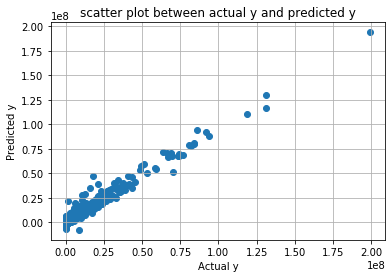

RMSE: 632023.117071


In [106]:
laso_regressor =Lasso(alpha= 0.06)
laso_regressor.fit(X_train, y_train)
preds = laso_regressor.predict(X_test)
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

### Random Forest Regressor

In [107]:
rf_regressor= RandomForestRegressor()
hyperparam_grid={"n_estimators": [10, 50, 100],"max_features": ["sqrt", "log2", 0.4, 0.5],\
                 "min_samples_leaf": [1, 3, 5],'max_depth':[5,10,15,30]}
rf_regressor_cv = GridSearchCV(rf_regressor,hyperparam_grid,cv=2)
rf_regressor_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",rf_regressor_cv.best_params_)
print("accuracy :",rf_regressor_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}
accuracy : 0.9607276124512972


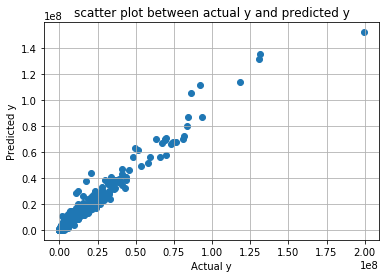

RMSE: 612541.449158


In [108]:
rf_regressor=RandomForestRegressor(max_depth= 15,max_features= 0.4, min_samples_leaf= 1, n_estimators=50)
rf_regressor.fit(X_train,y_train)

preds = rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print("RMSE: %f" % (rmse))

[13 16 18 12  9 11 17 23 20  7  6  8 14 24 21 25 15 19 10 22  5  4  3  0
  2  1]
[ 1  2  0  3  4  5 22 10 19 15 25 21 24 14  8  6  7 20 23 17 11  9 12 18
 16 13]


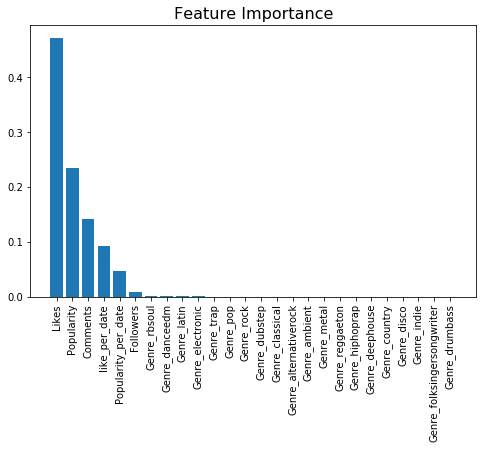

In [109]:
feature_importance = rf_regressor.feature_importances_
print(np.argsort(rf_regressor.feature_importances_))
indices = np.argsort(rf_regressor.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(8, 5))
plt.xticks(range(1,27), X.columns[indices], rotation=90)
plt.bar(range(1, 27), feature_importance[indices], align="center")
plt.title("Feature Importance", {"fontsize": 16});

### XGB Regressor

In [110]:
xgb_regressor=xgb.XGBRegressor()

n_estimators = [100, 500]
max_depth = [2, 3, 5, 10, 15]
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    }

# Set up the random search with 4-fold cross validation
xgb_regressor_cv = RandomizedSearchCV(estimator=xgb_regressor,
            param_distributions=hyperparameter_grid,
            cv=2,
            scoring = 'neg_mean_absolute_error',
            return_train_score = True,
            random_state=42)
xgb_regressor_cv.fit(X_train,y_train)
xgb_regressor_cv.best_estimator_

[11:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[11:39:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


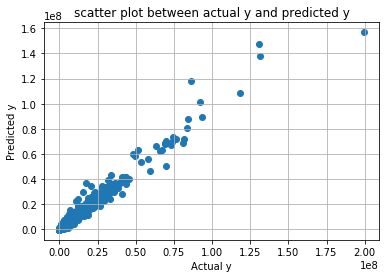

RMSE: 600474.351682


In [111]:
#regressor=xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.1, booster='gbtree', base_score=0.25)
xgb_regressor= xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
xgb_regressor.fit(X_train,y_train)

preds = xgb_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print("RMSE: %f" % (rmse))

In [112]:
#outliers
xgb_regressor.feature_importances_

array([8.4430929e-03, 9.2721063e-01, 7.1914494e-03, 3.2758466e-03,
       5.1983302e-03, 3.0051393e-03, 1.2616479e-03, 6.4479088e-04,
       3.5306457e-03, 1.7642690e-03, 2.3902948e-03, 2.1895445e-04,
       1.4405121e-04, 5.4429125e-05, 4.5001510e-04, 2.2678806e-03,
       1.1260960e-04, 1.1035288e-03, 5.8043324e-03, 1.1015189e-02,
       4.2449814e-04, 5.7330425e-03, 6.6122646e-03, 5.5480574e-04,
       1.0225333e-03, 5.6575378e-04], dtype=float32)

In [113]:
feature_importance = xgb_regressor.feature_importances_
print(np.argsort(xgb_regressor.feature_importances_))
indices = np.argsort(xgb_regressor.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(8, 5))
plt.xticks(range(1, 6), features_data.columns[indices], rotation=90)
plt.bar(range(1, 6), feature_importance[indices], align="center")
plt.title("Feature Importance", {"fontsize": 16});

[13 16 12 11 20 14 23 25  7 24 17  6  9 15 10  5  3  8  4 21 18 22  2  0
 19  1]
[ 1 19  0  2 22 18 21  4  8  3  5 10 15  9  6 17 24  7 25 23 14 20 11 12
 16 13]


AttributeError: 'list' object has no attribute 'columns'

<Figure size 576x360 with 0 Axes>

### Evaluation

In [ ]:
estimators = {"Lasso Regressor": laso_regressor,
              "Random Forest Regressor": rf_regressor,
              "XGB Regressor": xgb_regressor}
for estimator in estimators.keys():
    print('RMSE {}:{:.2f}'.format(estimator,np.sqrt(mean_squared_error(y_test, estimators[estimator].predict(X_test)))))

In [ ]:
# Saving model to disk
pickle.dump(rf_regressor, open('model_predictor.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model_predictor.pkl','rb'))

As per Competition evaluation metric RMSE and for **unseen data** is lesser for **XGB regressor(640358)** for  so we have selected it as a final model

### Generating Submission Data

In [ ]:
data_test = pd.read_csv('./data/Data_Test.csv')
label= data_test['Unique_ID']
data_test.drop(columns=['Unique_ID','Country','Name','Song_Name'],axis=1,inplace=True)
data_test['Likes'] = data_test.Likes.apply(popularityConverting)
data_test['Likes'] = data_test.Likes.astype('float')
data_test['Timestamp'] =pd.to_datetime(data_test['Timestamp'])
data_test['dayofweek'] = data_test['Timestamp'].dt.dayofweek #but mostly people on weekend
data_test['weekend'] = data_test['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
data_test['date_old']=(NOW-data_test['Timestamp']).dt.days
data_test['like_per_date']=data_test['Likes']/data_test['date_old']
data_test['followers_per_date']=data_test['Followers']/data_test['date_old']
data_test['Popularity'] = data_test.Popularity.apply(popularityConverting)
data_test['Popularity'] = data_test.Popularity.astype('float')
data_test['Popularity_per_date']=data_test['Popularity']/data_test['date_old']
dfnew= pd.get_dummies(data_test.loc[:,['Comments', 'Likes', 'Popularity','like_per_date','Popularity_per_date','Followers','Genre']],columns=['Genre'],drop_first=True)
X_testf=dfnew
X_testf.head()

In [ ]:
X_testf.shape

In [ ]:
X_testf= sc.transform(X_testf)
display(len(X_testf))
print(X_testf)
Y_pred = xgb_regressor.predict(X_testf)
display(len(Y_pred))

In [ ]:
print(Y_pred)
display(len(label))

In [ ]:
sub_df = pd.read_excel('./data/Sample_Submission.xlsx') 
submission = pd.DataFrame({
        "Unique_ID": label,
        "Views": Y_pred
    })
submission.to_excel('./data/Sample_Submission_Final.xlsx',index=False)

### Conclusion

As per competition we are getting highest score with XGBosst Regressor for unseen data.

In case of feature importance to **help Customerst to understand user behaviour and personalize the user experience** we will select random forest.

As per Random forest important features are **Likes ,Comments	,Popularity	,like_per_date	,Popularity_per_date**	
